In [70]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
from datetime import datetime, timedelta

In [80]:
def Check_Dates(df,header):
    print('Counts for '+header)
    print('Required no. of Days: ',(df.Date.max()-df.Date.min()).days,\
          'Existing no. of Days: ',len(df.Date.unique()),\
          'Missing no. Of Days: ',(df.Date.max()-df.Date.min()).days-len(df.Date.unique()))
def get_relevance_date(dt):
#     if dt.weekday()==5:
#         return(dt - timedelta(1))
#     elif dt.weekday()==6:
#         return(dt - timedelta(2))
#     elif dt.weekday()==0:
#         return(dt - timedelta(3))
#     else:
    return(dt- timedelta(1))

In [72]:
to_datetime = lambda d: datetime.strptime(d, "%Y-%m-%d")
df_data=pd.read_csv('../Data/Processed_Data/input_data_for_lda.csv',sep='|',converters={'Date': to_datetime},encoding = "ISO-8859-1")
# dictionary = gensim.corpora.Dictionary(df_data['Lemmetized_HL'].str.split())
# train_corpus = [dictionary.doc2bow(doc) for doc in df_data['Lemmetized_HL'].str.split()]
# lda_model = gensim.models.LdaMulticore(train_corpus, num_topics=20, id2word=dictionary, workers=2)
# lda_model=gensim.models.LdaMulticore(train_corpus)

In [73]:
# model = GridSearchCV(lda, param_grid=search_params)

In [74]:
dictionary = gensim.corpora.Dictionary(df_data['Lemmetized_HL'].str.split())
train_corpus = [dictionary.doc2bow(doc) for doc in df_data['Lemmetized_HL'].str.split()]
lda_model = gensim.models.LdaMulticore(train_corpus, num_topics=4, id2word=dictionary, workers=2)

In [75]:
df_data['Topic']=df_data['Lemmetized_HL']\
                .apply(lambda line: lda_model.get_document_topics(dictionary.doc2bow(line.split())))\
                .apply(lambda x:list(zip(*x))[0][list(zip(*x))[1].index(max(list(zip(*x))[1]))])
movement_class={'down':-1,'nomovement':0,'up':1}
df_data['MoveMent']=df_data['MoveMent'].replace(movement_class)

In [76]:
Check_Dates(price_data,'Price Data')
Check_Dates(df_data,'News Data')

Counts for Price Data
Required no. of Days:  4987 Existing no. of Days:  4988 Missing no. Of Days:  -1
Counts for News Data
Required no. of Days:  3720 Existing no. of Days:  2956 Missing no. Of Days:  764


In [82]:
def impute_missing_dates(df):
    flag=True
    while flag:
        d=df.sort_values('Date').Date.to_list()
        print('DataDate count:',len(d))
        date_set = set(d[0] + timedelta(x) for x in range((d[-1] - d[0]).days))
        print('Actual Date count:',len(date_set))
        missing = sorted(date_set - set(d))
        print('Missing Date count:',len(missing))
        # print(missing)
        missing_df=pd.DataFrame(missing,columns=['Date'])
        missing_df['Agg_Col2']=missing_df.Date.apply(lambda dt:get_relevance_date(dt))
        df=pd.concat([df[['Date', 'Agg_Col', 'MoveMent', 'Polarity', 'Subjectivity', 'Topic']],\
                      missing_df.join(df.set_index('Date'),on=['Agg_Col2'],how='left')[['Date', 'Agg_Col', 'MoveMent', 'Polarity', 'Subjectivity', 'Topic']]],\
                     axis=0,sort=False,ignore_index=True)
        if df.isna().sum().sum()==0:
            flag=False
        df.dropna(inplace=True)
        df.sort_values('Date',inplace=True)
        del(missing_df)
        del(missing)
        del(date_set)
        del(d)
    d=df.sort_values('Date').Date.to_list()
    print('DataDate count:',len(d))
    date_set = set(d[0] + timedelta(x) for x in range((d[-1] - d[0]).days))
    print('Actual Date count:',len(date_set))
    missing = sorted(date_set - set(d))
    print('Missing Date count:',len(missing))
    return df
new_df_data=df_data.drop(['Lemmetized_HL'],axis=1)
new_df_data.sort_values('Date',inplace=True)
new_df_data=impute_missing_dates(new_df_data)
Check_Dates(new_df_data,'DF Data')

DataDate count: 48305
Actual Date count: 3720
Missing Date count: 765
DataDate count: 51474
Actual Date count: 3720
Missing Date count: 449
DataDate count: 52417
Actual Date count: 3720
Missing Date count: 333
DataDate count: 52489
Actual Date count: 3720
Missing Date count: 284
DataDate count: 52531
Actual Date count: 3720
Missing Date count: 248
DataDate count: 52566
Actual Date count: 3720
Missing Date count: 219
DataDate count: 52597
Actual Date count: 3720
Missing Date count: 194
DataDate count: 52624
Actual Date count: 3720
Missing Date count: 173
DataDate count: 52646
Actual Date count: 3720
Missing Date count: 157
DataDate count: 52659
Actual Date count: 3720
Missing Date count: 144
DataDate count: 52670
Actual Date count: 3720
Missing Date count: 133
DataDate count: 52680
Actual Date count: 3720
Missing Date count: 123
DataDate count: 52690
Actual Date count: 3720
Missing Date count: 113
DataDate count: 52698
Actual Date count: 3720
Missing Date count: 105
DataDate count: 5270

In [84]:
final_data=new_df_data[['Date','Agg_Col','Topic']].drop_duplicates().join(new_df_data.groupby(by=['Agg_Col','Topic'])['MoveMent','Polarity','Subjectivity'].sum(), on=['Agg_Col','Topic'],how='inner')
final_data=final_data.groupby(['Date','Topic']).mean().reset_index().pivot(index='Date',columns='Topic',values=['MoveMent','Polarity','Subjectivity']).reset_index()
cols=['Topic'+str(x[1])+'_'+x[0] for x in final_data.columns[1:]]#.insert(0,'Date')
cols.insert(0,'Date')
final_data.columns=cols
final_data=final_data.fillna(0)
to_datetime = lambda d: datetime.strptime(d, "%Y-%m-%d")
price_data=pd.read_csv('../Data/NewsData/CrudePriceSmoothened.csv',sep='|',converters={'Date': to_datetime},encoding = "ISO-8859-1")
final_data=final_data.join(price_data.set_index('Date'), on=['Date'],how='inner')
final_data.to_csv('../Data/NewsData/ForecastInput.csv',sep='|',index=False)

In [87]:
final_data.head()

,Date,Topic0.0_MoveMent,Topic1.0_MoveMent,Topic2.0_MoveMent,Topic3.0_MoveMent,Topic0.0_Polarity,Topic1.0_Polarity,Topic2.0_Polarity,Topic3.0_Polarity,Topic0.0_Subjectivity,Topic1.0_Subjectivity,Topic2.0_Subjectivity,Topic3.0_Subjectivity,wtif_trend,DJIA_trend,USDX_trend,CP_trend
0,2009-07-24,59.0,0.0,0.0,0.0,-5.9,0.0,0.0,0.0,40.316667,0.0,0.0,0.0,0.007433,0.999880,0.011453,0.007333
1,2009-07-25,59.0,0.0,0.0,0.0,-5.9,0.0,0.0,0.0,40.316667,0.0,0.0,0.0,0.007444,0.999880,0.011414,0.007349
2,2009-07-26,59.0,0.0,0.0,0.0,-5.9,0.0,0.0,0.0,40.316667,0.0,0.0,0.0,0.007431,0.999880,0.011395,0.007354
3,2009-07-27,59.0,0.0,0.0,0.0,-5.9,0.0,0.0,0.0,40.316667,0.0,0.0,0.0,0.007397,0.999881,0.011386,0.007347
4,2009-07-28,59.0,0.0,0.0,0.0,-5.9,0.0,0.0,0.0,40.316667,0.0,0.0,0.0,0.007356,0.999881,0.011380,0.007328


In [88]:
final_data=final_data.sort_values('Date').set_index('Date')

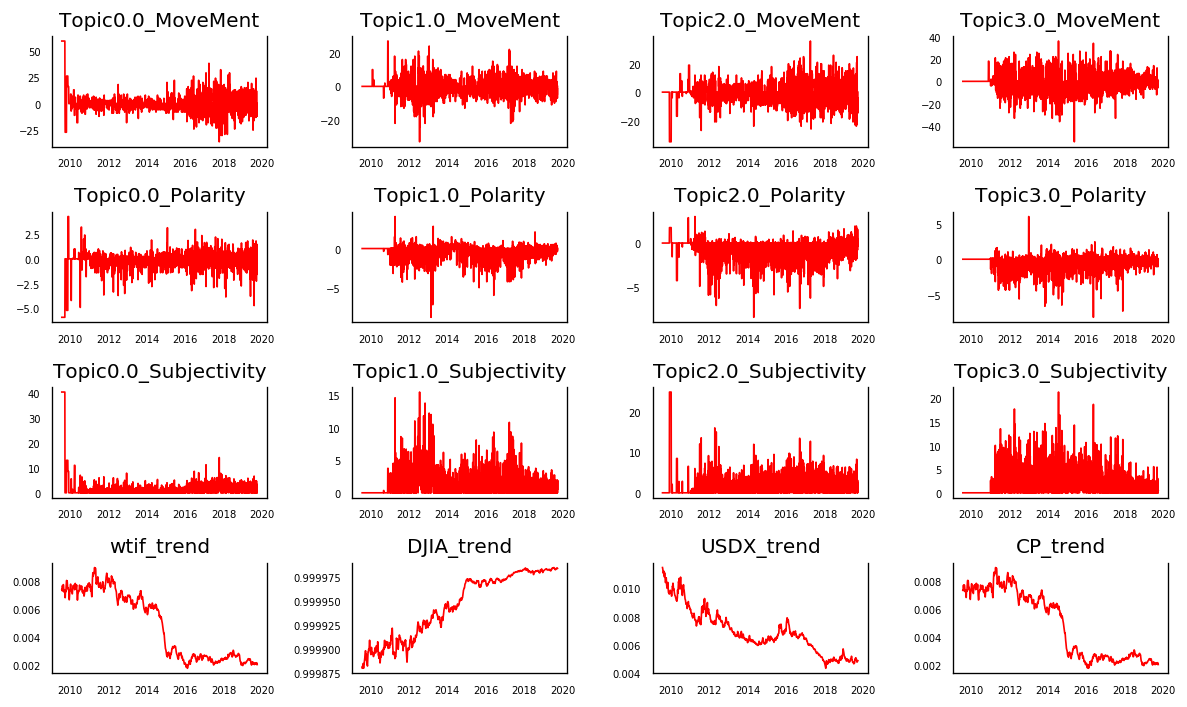

In [89]:
fig, axes = plt.subplots(nrows=4, ncols=4, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = final_data[final_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(final_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [90]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(final_data, variables = final_data.columns)        

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\R

,Topic0.0_MoveMent_x,Topic1.0_MoveMent_x,Topic2.0_MoveMent_x,Topic3.0_MoveMent_x,Topic0.0_Polarity_x,Topic1.0_Polarity_x,Topic2.0_Polarity_x,Topic3.0_Polarity_x,Topic0.0_Subjectivity_x,Topic1.0_Subjectivity_x,Topic2.0_Subjectivity_x,Topic3.0_Subjectivity_x,wtif_trend_x,DJIA_trend_x,USDX_trend_x,CP_trend_x
Topic0.0_MoveMent_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.3557,0.3691,0.0705,0.0000,0.4484,0.4364,0.1642,0.0000,0.0000,0.0002,0.0000
Topic1.0_MoveMent_y,0.0005,1.0000,0.0011,0.0000,0.5340,0.0350,0.3022,0.4894,0.6136,0.0000,0.6575,0.8419,0.0000,0.0000,0.1958,0.0000
Topic2.0_MoveMent_y,0.0000,0.0007,1.0000,0.0008,0.3671,0.2939,0.0072,0.1763,0.4359,0.4924,0.0000,0.3491,0.0000,0.0000,0.1005,0.0000
Topic3.0_MoveMent_y,0.0001,0.0000,0.0002,0.9569,0.5567,0.1425,0.2320,0.0776,0.4461,0.2341,0.5149,0.1192,0.0000,0.0000,0.0197,0.0000
Topic0.0_Polarity_y,0.0000,0.2240,0.0222,0.3492,1.0000,0.0288,0.1015,0.2642,0.0000,0.0042,0.0478,0.0013,0.0035,0.0000,0.0000,0.0053
Topic1.0_Polarity_y,0.0743,0.3838,0.3173,0.2338,0.0597,1.0000,0.0436,0.0748,0.0063,0.0001,0.6613,0.0020,0.0052,0.0082,0.1300,0.0047
Topic2.0_Polarity_y,0.0098,0.0250,0.2187,0.0232,0.0317,0.0994,1.0000,0.0001,0.0019,0.0041,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Topic3.0_Polarity_y,0.0795,0.2321,0.4781,0.0005,0.2793,0.0086,0.0010,1.0000,0.0002,0.0000,0.1892,0.0000,0.0049,0.2940,0.3819,0.0046
Topic0.0_Subjectivity_y,0.0000,0.5615,0.5190,0.8460,0.1072,0.0008,0.0023,0.0014,1.0000,0.0000,0.0008,0.0000,0.0969,0.1506,0.0142,0.1556
Topic1.0_Subjectivity_y,0.0318,0.0688,0.5450,0.2071,0.0414,0.0000,0.1065,0.0763,0.0000,1.0000,0.0747,0.0007,0.5395,0.4230,0.0519,0.5734


In [91]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(final_data[final_data.columns[:12]])
cointegration_test(final_data[final_data.columns[12:]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Topic0.0_MoveMent ::  3275.44   > 311.1288  =>   True
Topic1.0_MoveMent ::  2835.64   > 263.2603  =>   True
Topic2.0_MoveMent ::  2408.86   > 219.4051  =>   True
Topic3.0_MoveMent ::  2022.81   > 179.5199  =>   True
Topic0.0_Polarity ::  1648.41   > 143.6691  =>   True
Topic1.0_Polarity ::  1295.59   > 111.7797  =>   True
Topic2.0_Polarity ::  980.61    > 83.9383   =>   True
Topic3.0_Polarity ::  685.02    > 60.0627   =>   True
Topic0.0_Subjectivity ::  416.01    > 40.1749   =>   True
Topic1.0_Subjectivity ::  195.9     > 24.2761   =>   True
Topic2.0_Subjectivity ::  119.49    > 12.3212   =>   True
Topic3.0_Subjectivity ::  53.12     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
wtif_trend ::  175.9     > 40.1749   =>   True
DJIA_trend ::  18.96     > 24.2761   =>   False
USDX_trend ::  8.1       > 12.3212   =>   False
CP_trend ::  2.

In [95]:
nobs = 30
df_train, df_test = final_data[0:-nobs], final_data[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(3691, 16)
(30, 16)


In [96]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [97]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Topic0.0_MoveMent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.3197
 No. Lags Chosen       = 22
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Topic1.0_MoveMent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.8163
 No. Lags Chosen       = 4
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Topic2.0_MoveMent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-

In [98]:
df_train=df_train.diff().dropna()

In [110]:
help(df_train.diff)

Help on method diff in module pandas.core.frame:

diff(periods=1, axis=0) method of pandas.core.frame.DataFrame instance
    First discrete difference of element.
    
    Calculates the difference of a DataFrame element compared with another
    element in the DataFrame (default is the element in the same column
    of the previous row).
    
    Parameters
    ----------
    periods : int, default 1
        Periods to shift for calculating difference, accepts negative
        values.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Take difference over rows (0) or columns (1).
    
        .. versionadded:: 0.16.1.
    
    Returns
    -------
    DataFrame
    
    See Also
    --------
    Series.diff: First discrete difference for a Series.
    DataFrame.pct_change: Percent change over given number of periods.
    DataFrame.shift: Shift index by desired number of periods with an
        optional time freq.
    
    Examples
    --------
    Difference with previous row

In [99]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Topic0.0_MoveMent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.038
 No. Lags Chosen       = 30
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Topic1.0_MoveMent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.6692
 No. Lags Chosen       = 30
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Topic2.0_MoveMent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-

In [111]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  -90.03476137305894
BIC :  -89.57665182853567
FPE :  7.914079517346654e-40
HQIC:  -89.87170415750045 

Lag Order = 2
AIC :  -95.25293797155267
BIC :  -94.36346419153391
FPE :  4.2872417455421595e-42
HQIC:  -94.93633876826668 

Lag Order = 3
AIC :  -96.94477185646049
BIC :  -95.62373751303343
FPE :  7.896441246223628e-43
HQIC:  -96.47455654945466 

Lag Order = 4
AIC :  -97.21492013866536
BIC :  -95.46212875945784
FPE :  6.027289238729994e-43
HQIC:  -96.59101455581293 

Lag Order = 5
AIC :  -97.27778935098245
BIC :  -95.09304431901718
FPE :  5.660334363681506e-43
HQIC:  -96.50011926396465 

Lag Order = 6
AIC :  -97.40550914858386
BIC :  -94.78861370213264
FPE :  4.982065877020716e-43
HQIC:  -96.47400027283213 

Lag Order = 7
AIC :  -97.42241834974368
BIC :  -94.37317558218118
FPE :  4.899087189247811e-43
HQIC:  -96.33699634438176 

Lag Order = 8
AIC :  -97.43679869963177
BIC :  -93.95501155928933
FPE :  4.829869052474031e-43
HQIC:  -96.19738916741782 

Lag Order = 9
A

In [112]:
x = model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,-81.37,-81.34,4.606e-36,-81.36
1,-90.02,-89.55,8.067e-40,-89.85
2,-95.22,-94.33,4.422e-42,-94.90
3,-96.91,-95.58*,8.158e-43,-96.44
4,-97.18,-95.42,6.231e-43,-96.55*
5,-97.24,-95.05,5.864e-43,-96.46
6,-97.37,-94.73,5.184e-43,-96.43
7,-97.38,-94.31,5.111e-43,-96.29
8,-97.40,-93.90,5.021e-43,-96.15
9,-97.40*,-93.47,4.989e-43*,-96.00


In [113]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Feb, 2020
Time:                     01:05:32
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -93.5275
Nobs:                     3681.00    HQIC:                  -96.0485
Log likelihood:           98092.2    FPE:                4.80567e-43
AIC:                     -97.4420    Det(Omega_mle):     2.58993e-43
--------------------------------------------------------------------
Results for equation Topic0.0_MoveMent
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.032793         0.093906           -0.349           0.727
L1.Topic0.0_MoveMent             -0.292164         0.020110          -14.528           0.000


In [114]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_train.columns, out):
    print(col, ':', round(val, 2))

Topic0.0_MoveMent : 2.01
Topic1.0_MoveMent : 2.01
Topic2.0_MoveMent : 2.01
Topic3.0_MoveMent : 2.01
Topic0.0_Polarity : 2.01
Topic1.0_Polarity : 2.02
Topic2.0_Polarity : 2.01
Topic3.0_Polarity : 2.0
Topic0.0_Subjectivity : 2.0
Topic1.0_Subjectivity : 2.01
Topic2.0_Subjectivity : 2.0
Topic3.0_Subjectivity : 2.01
wtif_trend : 2.0
DJIA_trend : 2.0
USDX_trend : 1.99
CP_trend : 2.0


In [198]:
df_test_diff=df_test.diff().dropna()

In [212]:
nobs=27
fc = model_fitted.forecast(y=df_test_diff.values[:nobs], steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test_diff.index[:nobs], columns=df_test_diff.columns + '_1d')
df_forecast

,Topic0.0_MoveMent_1d,Topic1.0_MoveMent_1d,Topic2.0_MoveMent_1d,Topic3.0_MoveMent_1d,Topic0.0_Polarity_1d,Topic1.0_Polarity_1d,Topic2.0_Polarity_1d,Topic3.0_Polarity_1d,Topic0.0_Subjectivity_1d,Topic1.0_Subjectivity_1d,Topic2.0_Subjectivity_1d,Topic3.0_Subjectivity_1d,wtif_trend_1d,DJIA_trend_1d,USDX_trend_1d,CP_trend_1d
Date,,,,,,,,,,,,,,,,
2019-09-02,-3.635045,-1.476252,1.225956,-0.565745,0.075533,-0.057864,0.171222,0.053910,0.677761,0.235791,0.315172,0.660543,-1.497163e-05,5.228995e-08,1.230931e-06,-1.438915e-05
2019-09-03,0.296782,-0.404251,0.741507,-1.917869,0.160158,-0.106694,0.314269,-0.339768,0.105702,0.205777,-0.632111,0.036682,-1.361191e-05,6.565297e-08,-1.658422e-06,-1.337030e-05
2019-09-04,-0.321968,0.263070,0.406997,1.304248,0.003257,-0.081300,-0.147785,0.021459,0.015778,-0.165970,0.092500,-0.072517,-1.148223e-05,7.227676e-08,-3.542436e-06,-1.152527e-05
2019-09-05,-0.790265,-0.597888,0.443549,0.033486,0.085928,0.207973,-0.010021,-0.057894,-0.190569,-0.001906,-0.268195,0.049226,-9.020655e-06,6.941756e-08,-3.612463e-06,-9.294526e-06
2019-09-06,0.013595,0.016587,0.302212,0.763961,0.007137,-0.048311,0.054861,0.047935,0.145449,0.111748,0.092945,-0.126288,-6.760445e-06,5.831900e-08,-1.859186e-06,-7.210743e-06
2019-09-07,3.231877,0.660459,1.806477,1.285103,0.027239,-0.110408,-0.198883,-0.223519,-0.078833,0.280435,0.230156,0.744016,-4.572124e-06,4.538064e-08,-8.099519e-07,-5.146981e-06
2019-09-08,0.088582,0.624918,0.974639,0.961733,-0.112671,0.204370,0.316760,0.200731,0.037342,-0.127016,-0.287066,-0.603469,-2.426851e-06,2.897879e-08,-3.965239e-07,-2.994503e-06
2019-09-09,1.647519,0.504357,0.827759,0.873551,0.029408,-0.200715,-0.223201,0.132089,-0.074144,0.126791,0.301838,-0.044122,-1.024469e-06,1.911876e-08,-3.666087e-07,-1.558292e-06
2019-09-10,-0.838289,-0.176554,-0.357234,-0.785501,-0.008970,0.169465,-0.000730,-0.026109,-0.010993,-0.218975,-0.137647,-0.161777,-3.832044e-07,1.575300e-08,-5.563605e-07,-7.613181e-07


In [213]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
#         # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(df_test_diff, df_forecast)    
df_results

,Topic0.0_MoveMent_1d,Topic1.0_MoveMent_1d,Topic2.0_MoveMent_1d,Topic3.0_MoveMent_1d,Topic0.0_Polarity_1d,Topic1.0_Polarity_1d,Topic2.0_Polarity_1d,Topic3.0_Polarity_1d,Topic0.0_Subjectivity_1d,Topic1.0_Subjectivity_1d,...,Topic2.0_Polarity_forecast,Topic3.0_Polarity_forecast,Topic0.0_Subjectivity_forecast,Topic1.0_Subjectivity_forecast,Topic2.0_Subjectivity_forecast,Topic3.0_Subjectivity_forecast,wtif_trend_forecast,DJIA_trend_forecast,USDX_trend_forecast,CP_trend_forecast
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,-3.635045,-1.476252,1.225956,-0.565745,0.075533,-0.057864,0.171222,0.053910,0.677761,0.235791,...,-0.199675,0.332481,2.655034,-1.130876,-0.699980,0.653401,-0.000037,1.395051e-07,1.930509e-06,-0.000036
2019-09-03,0.296782,-0.404251,0.741507,-1.917869,0.160158,-0.106694,0.314269,-0.339768,0.105702,0.205777,...,0.114594,-0.007287,2.760736,-0.925099,-1.332091,0.690082,-0.000051,2.051580e-07,2.720871e-07,-0.000049
2019-09-04,-0.321968,0.263070,0.406997,1.304248,0.003257,-0.081300,-0.147785,0.021459,0.015778,-0.165970,...,-0.033191,0.014172,2.776514,-1.091069,-1.239591,0.617565,-0.000062,2.774348e-07,-3.270349e-06,-0.000061
2019-09-05,-0.790265,-0.597888,0.443549,0.033486,0.085928,0.207973,-0.010021,-0.057894,-0.190569,-0.001906,...,-0.043212,-0.043722,2.585946,-1.092975,-1.507786,0.666791,-0.000072,3.468524e-07,-6.882812e-06,-0.000070
2019-09-06,0.013595,0.016587,0.302212,0.763961,0.007137,-0.048311,0.054861,0.047935,0.145449,0.111748,...,0.011649,0.004213,2.731395,-0.981226,-1.414841,0.540503,-0.000078,4.051714e-07,-8.741998e-06,-0.000077
2019-09-07,3.231877,0.660459,1.806477,1.285103,0.027239,-0.110408,-0.198883,-0.223519,-0.078833,0.280435,...,-0.187234,-0.219306,2.652561,-0.700792,-1.184685,1.284519,-0.000083,4.505520e-07,-9.551949e-06,-0.000083
2019-09-08,0.088582,0.624918,0.974639,0.961733,-0.112671,0.204370,0.316760,0.200731,0.037342,-0.127016,...,0.129527,-0.018575,2.689904,-0.827808,-1.471751,0.681051,-0.000085,4.795308e-07,-9.948473e-06,-0.000086
2019-09-09,1.647519,0.504357,0.827759,0.873551,0.029408,-0.200715,-0.223201,0.132089,-0.074144,0.126791,...,-0.093674,0.113514,2.615759,-0.701018,-1.169914,0.636929,-0.000086,4.986496e-07,-1.031508e-05,-0.000087
2019-09-10,-0.838289,-0.176554,-0.357234,-0.785501,-0.008970,0.169465,-0.000730,-0.026109,-0.010993,-0.218975,...,-0.094404,0.087405,2.604766,-0.919993,-1.307561,0.475151,-0.000087,5.144026e-07,-1.087144e-05,-0.000088


In [214]:
df_results[['Topic0.0_MoveMent_forecast', 'Topic1.0_MoveMent_forecast',
       'Topic2.0_MoveMent_forecast', 'Topic3.0_MoveMent_forecast',
       'Topic0.0_Polarity_forecast', 'Topic1.0_Polarity_forecast',
       'Topic2.0_Polarity_forecast', 'Topic3.0_Polarity_forecast',
       'Topic0.0_Subjectivity_forecast', 'Topic1.0_Subjectivity_forecast',
       'Topic2.0_Subjectivity_forecast', 'Topic3.0_Subjectivity_forecast',
       'wtif_trend_forecast', 'DJIA_trend_forecast', 'USDX_trend_forecast',
       'CP_trend_forecast']]

,Topic0.0_MoveMent_forecast,Topic1.0_MoveMent_forecast,Topic2.0_MoveMent_forecast,Topic3.0_MoveMent_forecast,Topic0.0_Polarity_forecast,Topic1.0_Polarity_forecast,Topic2.0_Polarity_forecast,Topic3.0_Polarity_forecast,Topic0.0_Subjectivity_forecast,Topic1.0_Subjectivity_forecast,Topic2.0_Subjectivity_forecast,Topic3.0_Subjectivity_forecast,wtif_trend_forecast,DJIA_trend_forecast,USDX_trend_forecast,CP_trend_forecast
Date,,,,,,,,,,,,,,,,
2019-09-02,-3.635045,5.523748,15.225956,3.434255,-0.314619,-0.311652,-0.199675,0.332481,2.655034,-1.130876,-0.699980,0.653401,-0.000037,1.395051e-07,1.930509e-06,-0.000036
2019-09-03,-3.338263,5.119497,15.967463,1.516387,-0.154461,-0.418346,0.114594,-0.007287,2.760736,-0.925099,-1.332091,0.690082,-0.000051,2.051580e-07,2.720871e-07,-0.000049
2019-09-04,-3.660231,5.382567,16.374461,2.820635,-0.151204,-0.499645,-0.033191,0.014172,2.776514,-1.091069,-1.239591,0.617565,-0.000062,2.774348e-07,-3.270349e-06,-0.000061
2019-09-05,-4.450496,4.784679,16.818010,2.854121,-0.065276,-0.291672,-0.043212,-0.043722,2.585946,-1.092975,-1.507786,0.666791,-0.000072,3.468524e-07,-6.882812e-06,-0.000070
2019-09-06,-4.436901,4.801266,17.120222,3.618083,-0.058139,-0.339984,0.011649,0.004213,2.731395,-0.981226,-1.414841,0.540503,-0.000078,4.051714e-07,-8.741998e-06,-0.000077
2019-09-07,-1.205024,5.461725,18.926699,4.903185,-0.030900,-0.450392,-0.187234,-0.219306,2.652561,-0.700792,-1.184685,1.284519,-0.000083,4.505520e-07,-9.551949e-06,-0.000083
2019-09-08,-1.116442,6.086643,19.901337,5.864918,-0.143571,-0.246022,0.129527,-0.018575,2.689904,-0.827808,-1.471751,0.681051,-0.000085,4.795308e-07,-9.948473e-06,-0.000086
2019-09-09,0.531077,6.591000,20.729096,6.738469,-0.114163,-0.446737,-0.093674,0.113514,2.615759,-0.701018,-1.169914,0.636929,-0.000086,4.986496e-07,-1.031508e-05,-0.000087
2019-09-10,-0.307212,6.414446,20.371863,5.952969,-0.123133,-0.277272,-0.094404,0.087405,2.604766,-0.919993,-1.307561,0.475151,-0.000087,5.144026e-07,-1.087144e-05,-0.000088


In [215]:
df_train.columns

Index(['Topic0.0_MoveMent', 'Topic1.0_MoveMent', 'Topic2.0_MoveMent',
       'Topic3.0_MoveMent', 'Topic0.0_Polarity', 'Topic1.0_Polarity',
       'Topic2.0_Polarity', 'Topic3.0_Polarity', 'Topic0.0_Subjectivity',
       'Topic1.0_Subjectivity', 'Topic2.0_Subjectivity',
       'Topic3.0_Subjectivity', 'wtif_trend', 'DJIA_trend', 'USDX_trend',
       'CP_trend'],
      dtype='object')

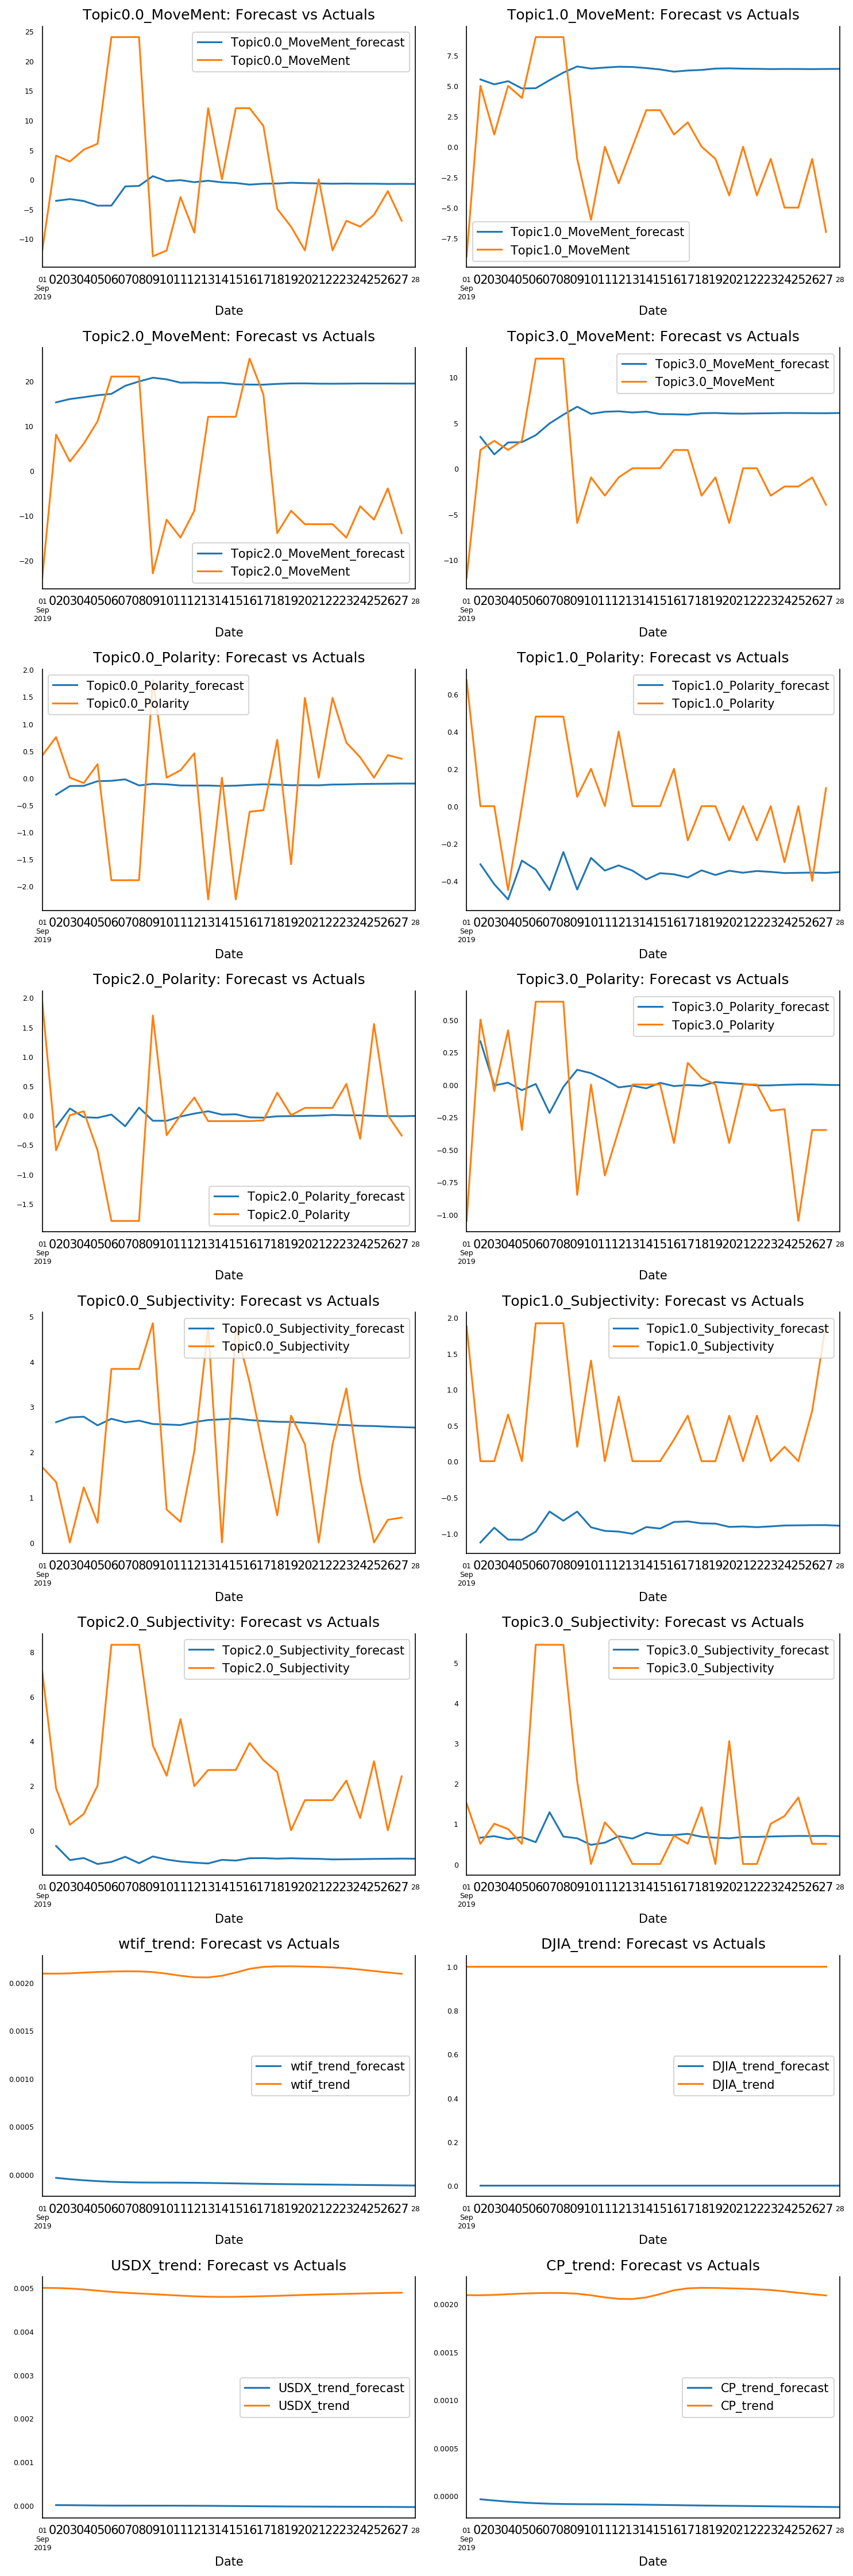

In [216]:
fig, axes = plt.subplots(nrows=int(len(df_train.columns)/2), ncols=2, dpi=150, figsize=(10,30))
for i, (col,ax) in enumerate(zip(df_train.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][:nobs].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [217]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

for cols in ['Topic0.0_MoveMent', 'Topic1.0_MoveMent', 'Topic2.0_MoveMent',
       'Topic3.0_MoveMent', 'Topic0.0_Polarity', 'Topic1.0_Polarity',
       'Topic2.0_Polarity', 'Topic3.0_Polarity', 'Topic0.0_Subjectivity',
       'Topic1.0_Subjectivity', 'Topic2.0_Subjectivity',
       'Topic3.0_Subjectivity', 'wtif_trend', 'DJIA_trend', 'USDX_trend',
       'CP_trend']:
    print('Forecast Accuracy of: '+cols)
    accuracy_prod = forecast_accuracy(df_results[cols+'_forecast'].values, df_test[cols][:nobs])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of: Topic0.0_MoveMent
mape :  inf
me :  -1.9319
mae :  9.69
mpe :  -inf
rmse :  11.6054
corr :  -0.0599
minmax :  inf
Forecast Accuracy of: Topic1.0_MoveMent
mape :  inf
me :  5.9717
mae :  6.644
mpe :  inf
rmse :  7.7281
corr :  -0.3605
minmax :  1.0425
Forecast Accuracy of: Topic2.0_MoveMent
mape :  2.0317
me :  19.8627
mae :  20.5486
mpe :  -1.1041
rmse :  24.6691
corr :  0.0026
minmax :  1.0828
Forecast Accuracy of: Topic3.0_MoveMent
mape :  inf
me :  5.2369
mae :  6.6559
mpe :  inf
rmse :  7.5352
corr :  -0.0306
minmax :  1.1334
Forecast Accuracy of: Topic0.0_Polarity
mape :  inf
me :  0.0137
mae :  0.8816
mpe :  -inf
rmse :  1.1233
corr :  -0.1314
minmax :  inf
Forecast Accuracy of: Topic1.0_Polarity
mape :  inf
me :  -0.4092
mae :  0.4241
mpe :  -inf
rmse :  0.4918
corr :  -0.0758
minmax :  inf
Forecast Accuracy of: Topic2.0_Polarity
mape :  inf
me :  0.0313
mae :  0.5649
mpe :  nan
rmse :  0.8867
corr :  -0.2256
minmax :  inf
Forecast Accuracy of: Topic3.0_Pol

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [209]:
df_test[cols][:9]

Date
2019-09-01   -12.0
2019-09-02     4.0
2019-09-03     3.0
2019-09-04     5.0
2019-09-05     6.0
2019-09-06    24.0
2019-09-07    24.0
2019-09-08    24.0
2019-09-09   -13.0
Name: Topic0.0_MoveMent, dtype: float64

In [218]:
import pickle
pickle_in = open("std_scaler.pickle","rb")
example_dict = pickle.load(pickle_in)

In [221]:
pd.DataFrame(example_dict.inverse_transform(df_test[['wtif_trend', 'DJIA_trend', 'USDX_trend','CP_trend']]),columns=['WTI_FUTURES','DJIA','USDX','CrudePrice'])

,WTI_FUTURES,DJIA,USDX,CrudePrice
0,73.698623,20728.861402,109.272990,73.609383
1,73.698601,20728.861543,109.272940,73.609361
2,73.698681,20728.861727,109.272832,73.609441
3,73.698850,20728.862120,109.272602,73.609609
4,73.698988,20728.862705,109.272305,73.609746
5,73.699092,20728.863278,109.272028,73.609845
6,73.699147,20728.863757,109.271808,73.609897
7,73.699123,20728.864201,109.271631,73.609874
8,73.698965,20728.864739,109.271467,73.609719
9,73.698599,20728.865498,109.271294,73.609351


In [223]:
pd.DataFrame(example_dict.inverse_transform(df_results[['wtif_trend_forecast', 'DJIA_trend_forecast', 'USDX_trend_forecast',
       'CP_trend_forecast']]),columns=['WTI_FUTURES','DJIA','USDX','CrudePrice'])

,WTI_FUTURES,DJIA,USDX,CrudePrice
0,73.651291,15610.678415,109.220776,73.561921
1,73.650988,15610.678751,109.220759,73.561623
2,73.650733,15610.679121,109.220722,73.561366
3,73.650532,15610.679476,109.220684,73.561159
4,73.650382,15610.679775,109.220665,73.560998
5,73.650281,15610.680007,109.220656,73.560883
6,73.650227,15610.680155,109.220652,73.560816
7,73.650204,15610.680253,109.220648,73.560781
8,73.650195,15610.680334,109.220642,73.560765
9,73.650182,15610.680446,109.220633,73.560749
